# Lab 2: Per-pixel Feature Extraction
University of the Witwatersrand, Johannesburg
COMS4036A & COMS7050A | Computer Vision
Devon Jarvis, Nathan Michlo, Prof. Richard Klein

## Instructions
This notebook implements advanced feature extraction and pixel classification for background segmentation. Each section corresponds to a lab question and includes code, mathematical explanations, and visualizations.

## Imports & Setup

In [41]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

## Load Images and Masks

In [42]:
train_img = cv2.imread('images/image-35.jpg')
train_mask = cv2.imread('images/mask-35.png', cv2.IMREAD_GRAYSCALE)
val_img = cv2.imread('images/image-83.jpg')
val_mask = cv2.imread('images/mask-83.png', cv2.IMREAD_GRAYSCALE)
test_img = cv2.imread('images/image-110.jpg')
test_mask = cv2.imread('images/mask-110.png', cv2.IMREAD_GRAYSCALE)
train_img_rgb = cv2.cvtColor(train_img, cv2.COLOR_BGR2RGB)
val_img_rgb = cv2.cvtColor(val_img, cv2.COLOR_BGR2RGB)
test_img_rgb = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
train_mask_binary = (train_mask > 127).astype(int)
val_mask_binary = (val_mask > 127).astype(int)
test_mask_binary = (test_mask > 127).astype(int)
train_img_hsv = cv2.cvtColor(train_img_rgb, cv2.COLOR_RGB2HSV)
val_img_hsv = cv2.cvtColor(val_img_rgb, cv2.COLOR_RGB2HSV)
test_img_hsv = cv2.cvtColor(test_img_rgb, cv2.COLOR_RGB2HSV)

## Prewitt and Laplacian Filters
**Prewitt:**
$$G_x = \begin{bmatrix}-1 & 0 & 1 \\ -1 & 0 & 1 \\ -1 & 0 & 1\end{bmatrix}, \quad G_y = \begin{bmatrix}-1 & -1 & -1 \\ 0 & 0 & 0 \\ 1 & 1 & 1\end{bmatrix}$$

**Laplacian:**
$$L = \begin{bmatrix}0 & -1 & 0 \\ -1 & 4 & -1 \\ 0 & -1 & 0\end{bmatrix}$$

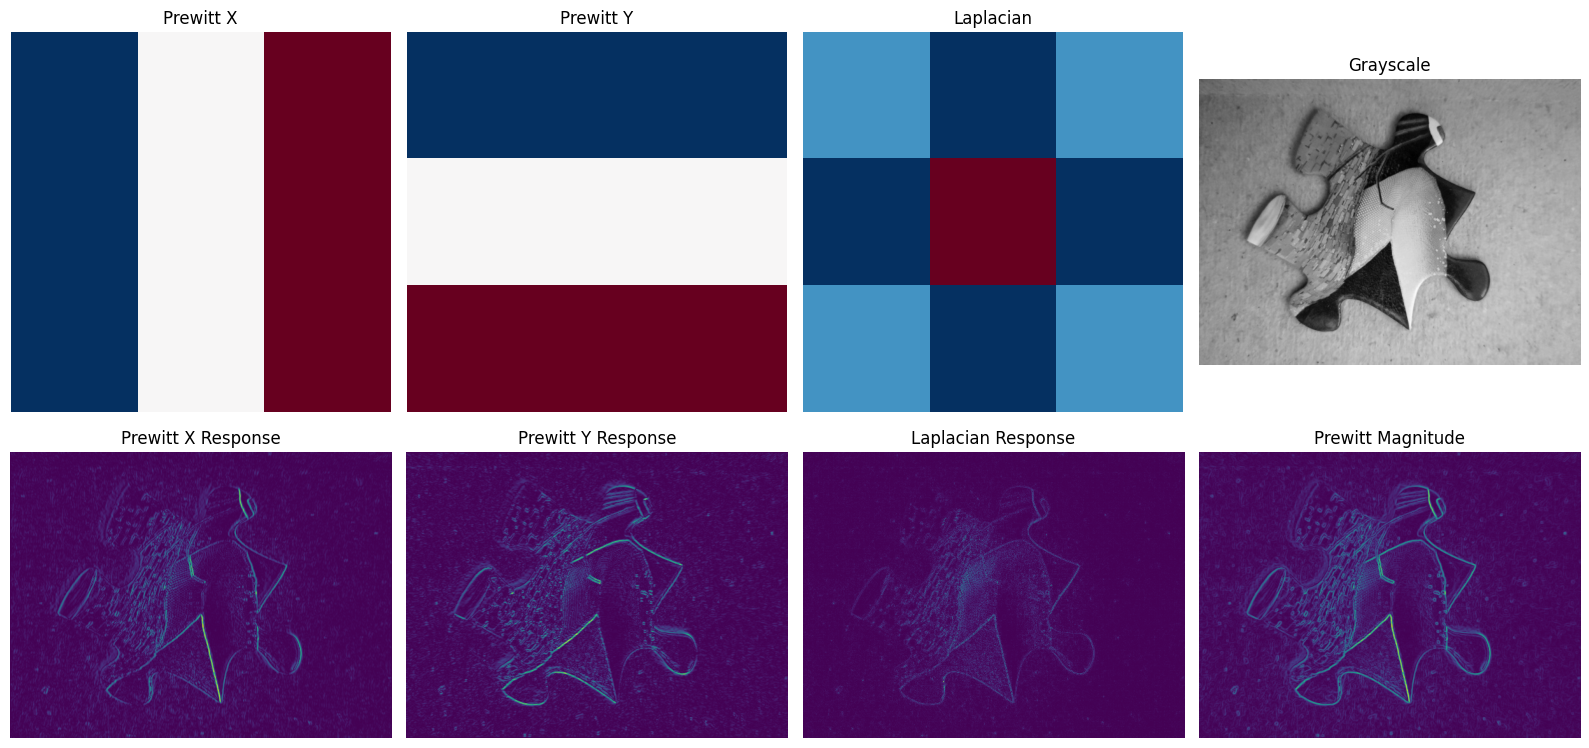

In [43]:
def create_prewitt_filters():
    prewitt_x = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]], dtype=np.float32)
    prewitt_y = np.array([[-1, -1, -1], [0, 0, 0], [1, 1, 1]], dtype=np.float32)
    return prewitt_x, prewitt_y

def create_laplacian_filter():
    return np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]], dtype=np.float32)

prewitt_x, prewitt_y = create_prewitt_filters()
laplacian_kernel = create_laplacian_filter()
train_gray = cv2.cvtColor(train_img_rgb, cv2.COLOR_RGB2GRAY).astype(np.float32)
prewitt_x_response = cv2.filter2D(train_gray, -1, prewitt_x)
prewitt_y_response = cv2.filter2D(train_gray, -1, prewitt_y)
laplacian_response = cv2.filter2D(train_gray, -1, laplacian_kernel)
prewitt_magnitude = np.sqrt(prewitt_x_response**2 + prewitt_y_response**2)

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes[0, 0].imshow(prewitt_x, cmap='RdBu_r'); axes[0, 0].set_title('Prewitt X'); axes[0, 0].axis('off')
axes[0, 1].imshow(prewitt_y, cmap='RdBu_r'); axes[0, 1].set_title('Prewitt Y'); axes[0, 1].axis('off')
axes[0, 2].imshow(laplacian_kernel, cmap='RdBu_r'); axes[0, 2].set_title('Laplacian'); axes[0, 2].axis('off')
axes[0, 3].imshow(train_gray, cmap='gray'); axes[0, 3].set_title('Grayscale'); axes[0, 3].axis('off')
axes[1, 0].imshow(np.abs(prewitt_x_response), cmap='viridis'); axes[1, 0].set_title('Prewitt X Response'); axes[1, 0].axis('off')
axes[1, 1].imshow(np.abs(prewitt_y_response), cmap='viridis'); axes[1, 1].set_title('Prewitt Y Response'); axes[1, 1].axis('off')
axes[1, 2].imshow(np.abs(laplacian_response), cmap='viridis'); axes[1, 2].set_title('Laplacian Response'); axes[1, 2].axis('off')
axes[1, 3].imshow(prewitt_magnitude, cmap='viridis'); axes[1, 3].set_title('Prewitt Magnitude'); axes[1, 3].axis('off')
plt.tight_layout(); plt.show()

## 1. Gaussian, LoG, and DoG Filters
**Gaussian:**
$$g(x, y) = \frac{1}{2\pi\sigma^2} e^{-\frac{x^2 + y^2}{2\sigma^2}}$$

**LoG:**
$$g(x, y) = -\frac{1}{\pi\sigma^4} \left(1 - \frac{x^2 + y^2}{2\sigma^2}\right) e^{-\frac{x^2 + y^2}{2\sigma^2}}$$

**DoG:**
$$g(x, y) = \frac{1}{2\pi\sigma^2} e^{-\frac{x^2 + y^2}{2\sigma^2}} - \frac{1}{2\pi K^2\sigma^2} e^{-\frac{x^2 + y^2}{2K^2\sigma^2}}$$

In [44]:
def create_gaussian_filter(size, sigma):
    center = size // 2
    x, y = np.meshgrid(np.arange(-center, center + 1), np.arange(-center, center + 1))
    gaussian = (1 / (2 * np.pi * sigma**2)) * np.exp(-(x**2 + y**2) / (2 * sigma**2))
    return gaussian / np.sum(gaussian)

def create_log_filter(size, sigma):
    center = size // 2
    x, y = np.meshgrid(np.arange(-center, center + 1), np.arange(-center, center + 1))
    r_squared = x**2 + y**2
    log_filter = -(1 / (np.pi * sigma**4)) * (1 - r_squared / (2 * sigma**2)) * np.exp(-r_squared / (2 * sigma**2))
    return log_filter / np.sum(np.abs(log_filter))

def create_dog_filter(size, sigma, k=1.6):
    center = size // 2
    x, y = np.meshgrid(np.arange(-center, center + 1), np.arange(-center, center + 1))
    r_squared = x**2 + y**2
    gaussian1 = (1 / (2 * np.pi * sigma**2)) * np.exp(-r_squared / (2 * sigma**2))
    gaussian2 = (1 / (2 * np.pi * (k * sigma)**2)) * np.exp(-r_squared / (2 * (k * sigma)**2))
    return gaussian1 - gaussian2

#### Example usage of Gaussian, LoG, and DoG filters


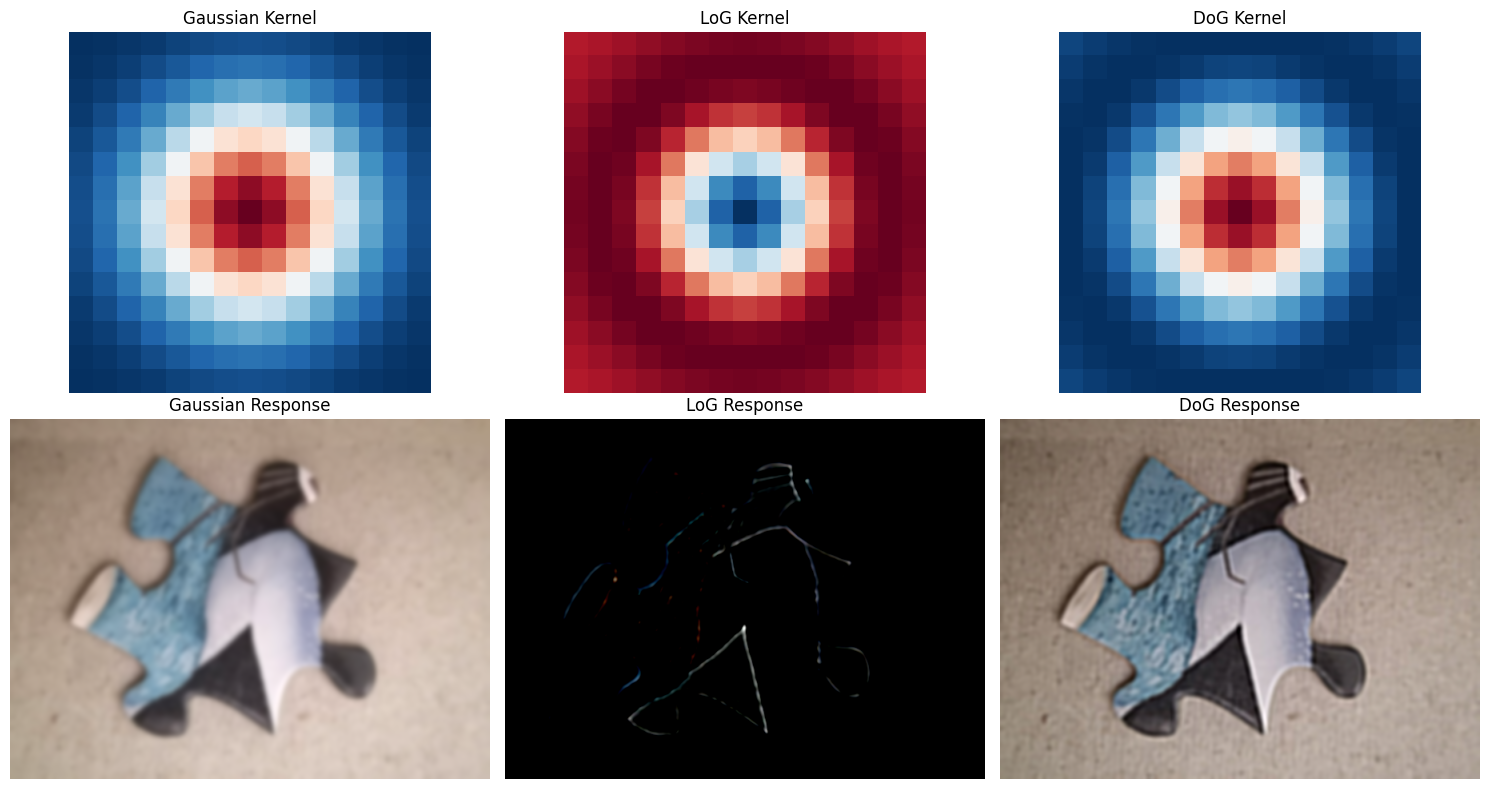

In [45]:
# Create filters
gaussian_kernel = create_gaussian_filter(size=15, sigma=3)
log_kernel = create_log_filter(size=15, sigma=3)
dog_kernel = create_dog_filter(size=15, sigma=3)

# Apply filters to each RGB channel
gaussian_response = np.zeros_like(train_img_rgb, dtype=np.float32)
log_response = np.zeros_like(train_img_rgb, dtype=np.float32)
dog_response = np.zeros_like(train_img_rgb, dtype=np.float32)

for c in range(3):
    channel = train_img_rgb[:, :, c].astype(np.float32)
    gaussian_response[:, :, c] = cv2.filter2D(channel, -1, gaussian_kernel)
    log_response[:, :, c] = cv2.filter2D(channel, -1, log_kernel)
    dog_response[:, :, c] = cv2.filter2D(channel, -1, dog_kernel)

# Visualize kernels and responses
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes[0, 0].imshow(gaussian_kernel, cmap='RdBu_r'); axes[0, 0].set_title('Gaussian Kernel'); axes[0, 0].axis('off')
axes[0, 1].imshow(log_kernel, cmap='RdBu_r'); axes[0, 1].set_title('LoG Kernel'); axes[0, 1].axis('off')
axes[0, 2].imshow(dog_kernel, cmap='RdBu_r'); axes[0, 2].set_title('DoG Kernel'); axes[0, 2].axis('off')
axes[1, 0].imshow(np.clip(gaussian_response / np.max(gaussian_response), 0, 1)); axes[1, 0].set_title('Gaussian Response'); axes[1, 0].axis('off')
axes[1, 1].imshow(np.clip(log_response / np.max(log_response), 0, 1)); axes[1, 1].set_title('LoG Response'); axes[1, 1].axis('off')
axes[1, 2].imshow(np.clip(dog_response / np.max(dog_response), 0, 1)); axes[1, 2].set_title('DoG Response'); axes[1, 2].axis('off')
plt.tight_layout(); plt.show()

## 2.1 RFS/MR8 Filter Banks
### Gaussian Edge and Bar Filters
$$g(x, y, \theta, \sigma_x, \sigma_y) = f(x', \sigma_x) \cdot f(y', \sigma_y)$$

Edge: $\frac{d}{dy'}g(x, y, \theta, \sigma_x, \sigma_y)$

Bar: $\frac{d^2}{dy'^2}g(x, y, \theta, \sigma_x, \sigma_y)$

In [46]:
def create_gaussian_derivative_filter(theta, sigma_x, sigma_y, size, derivative_order):
    if isinstance(size, int): size = (size, size)
    h, w = size
    center_x, center_y = w // 2, h // 2
    x, y = np.meshgrid(np.arange(-center_x, center_x + 1), np.arange(-center_y, center_y + 1))
    x_prime = x * np.cos(theta) - y * np.sin(theta)
    y_prime = x * np.sin(theta) + y * np.cos(theta)
    f_x_prime = (1 / np.sqrt(2 * np.pi * sigma_x**2)) * np.exp(-x_prime**2 / (2 * sigma_x**2))
    f_y_prime = (1 / np.sqrt(2 * np.pi * sigma_y**2)) * np.exp(-y_prime**2 / (2 * sigma_y**2))
    if derivative_order == 1:
        df_dy_prime = f_y_prime * (-y_prime / sigma_y**2)
        filter_kernel = f_x_prime * df_dy_prime
    elif derivative_order == 2:
        d2f_dy2_prime = f_y_prime * (y_prime**2 - sigma_y**2) / sigma_y**4
        filter_kernel = f_x_prime * d2f_dy2_prime
    else:
        raise ValueError('derivative_order must be 1 or 2')
    return np.flipud(filter_kernel)

### RFS Filter Bank Construction

In [47]:
def create_rfs_filter_bank():
    filters = []
    gaussian_sigma = np.sqrt(10)
    filters.append({'filter': create_gaussian_filter(49, gaussian_sigma), 'type': 'Gaussian', 'params': {'sigma': gaussian_sigma}})
    filters.append({'filter': create_log_filter(49, gaussian_sigma), 'type': 'LoG', 'params': {'sigma': gaussian_sigma}})
    sigma_pairs = [(3, 1), (6, 2), (12, 4)]
    thetas = [0, np.pi/6, 2*np.pi/6, 3*np.pi/6, 4*np.pi/6, 5*np.pi/6]
    for sigma_x, sigma_y in sigma_pairs:
        for theta in thetas:
            filters.append({'filter': create_gaussian_derivative_filter(theta, sigma_x, sigma_y, 49, 1), 'type': 'Edge', 'params': {'theta': theta, 'sigma_x': sigma_x, 'sigma_y': sigma_y}})
            filters.append({'filter': create_gaussian_derivative_filter(theta, sigma_x, sigma_y, 49, 2), 'type': 'Bar', 'params': {'theta': theta, 'sigma_x': sigma_x, 'sigma_y': sigma_y}})
    return filters

### 2.2 Plotting RFS Filter banks

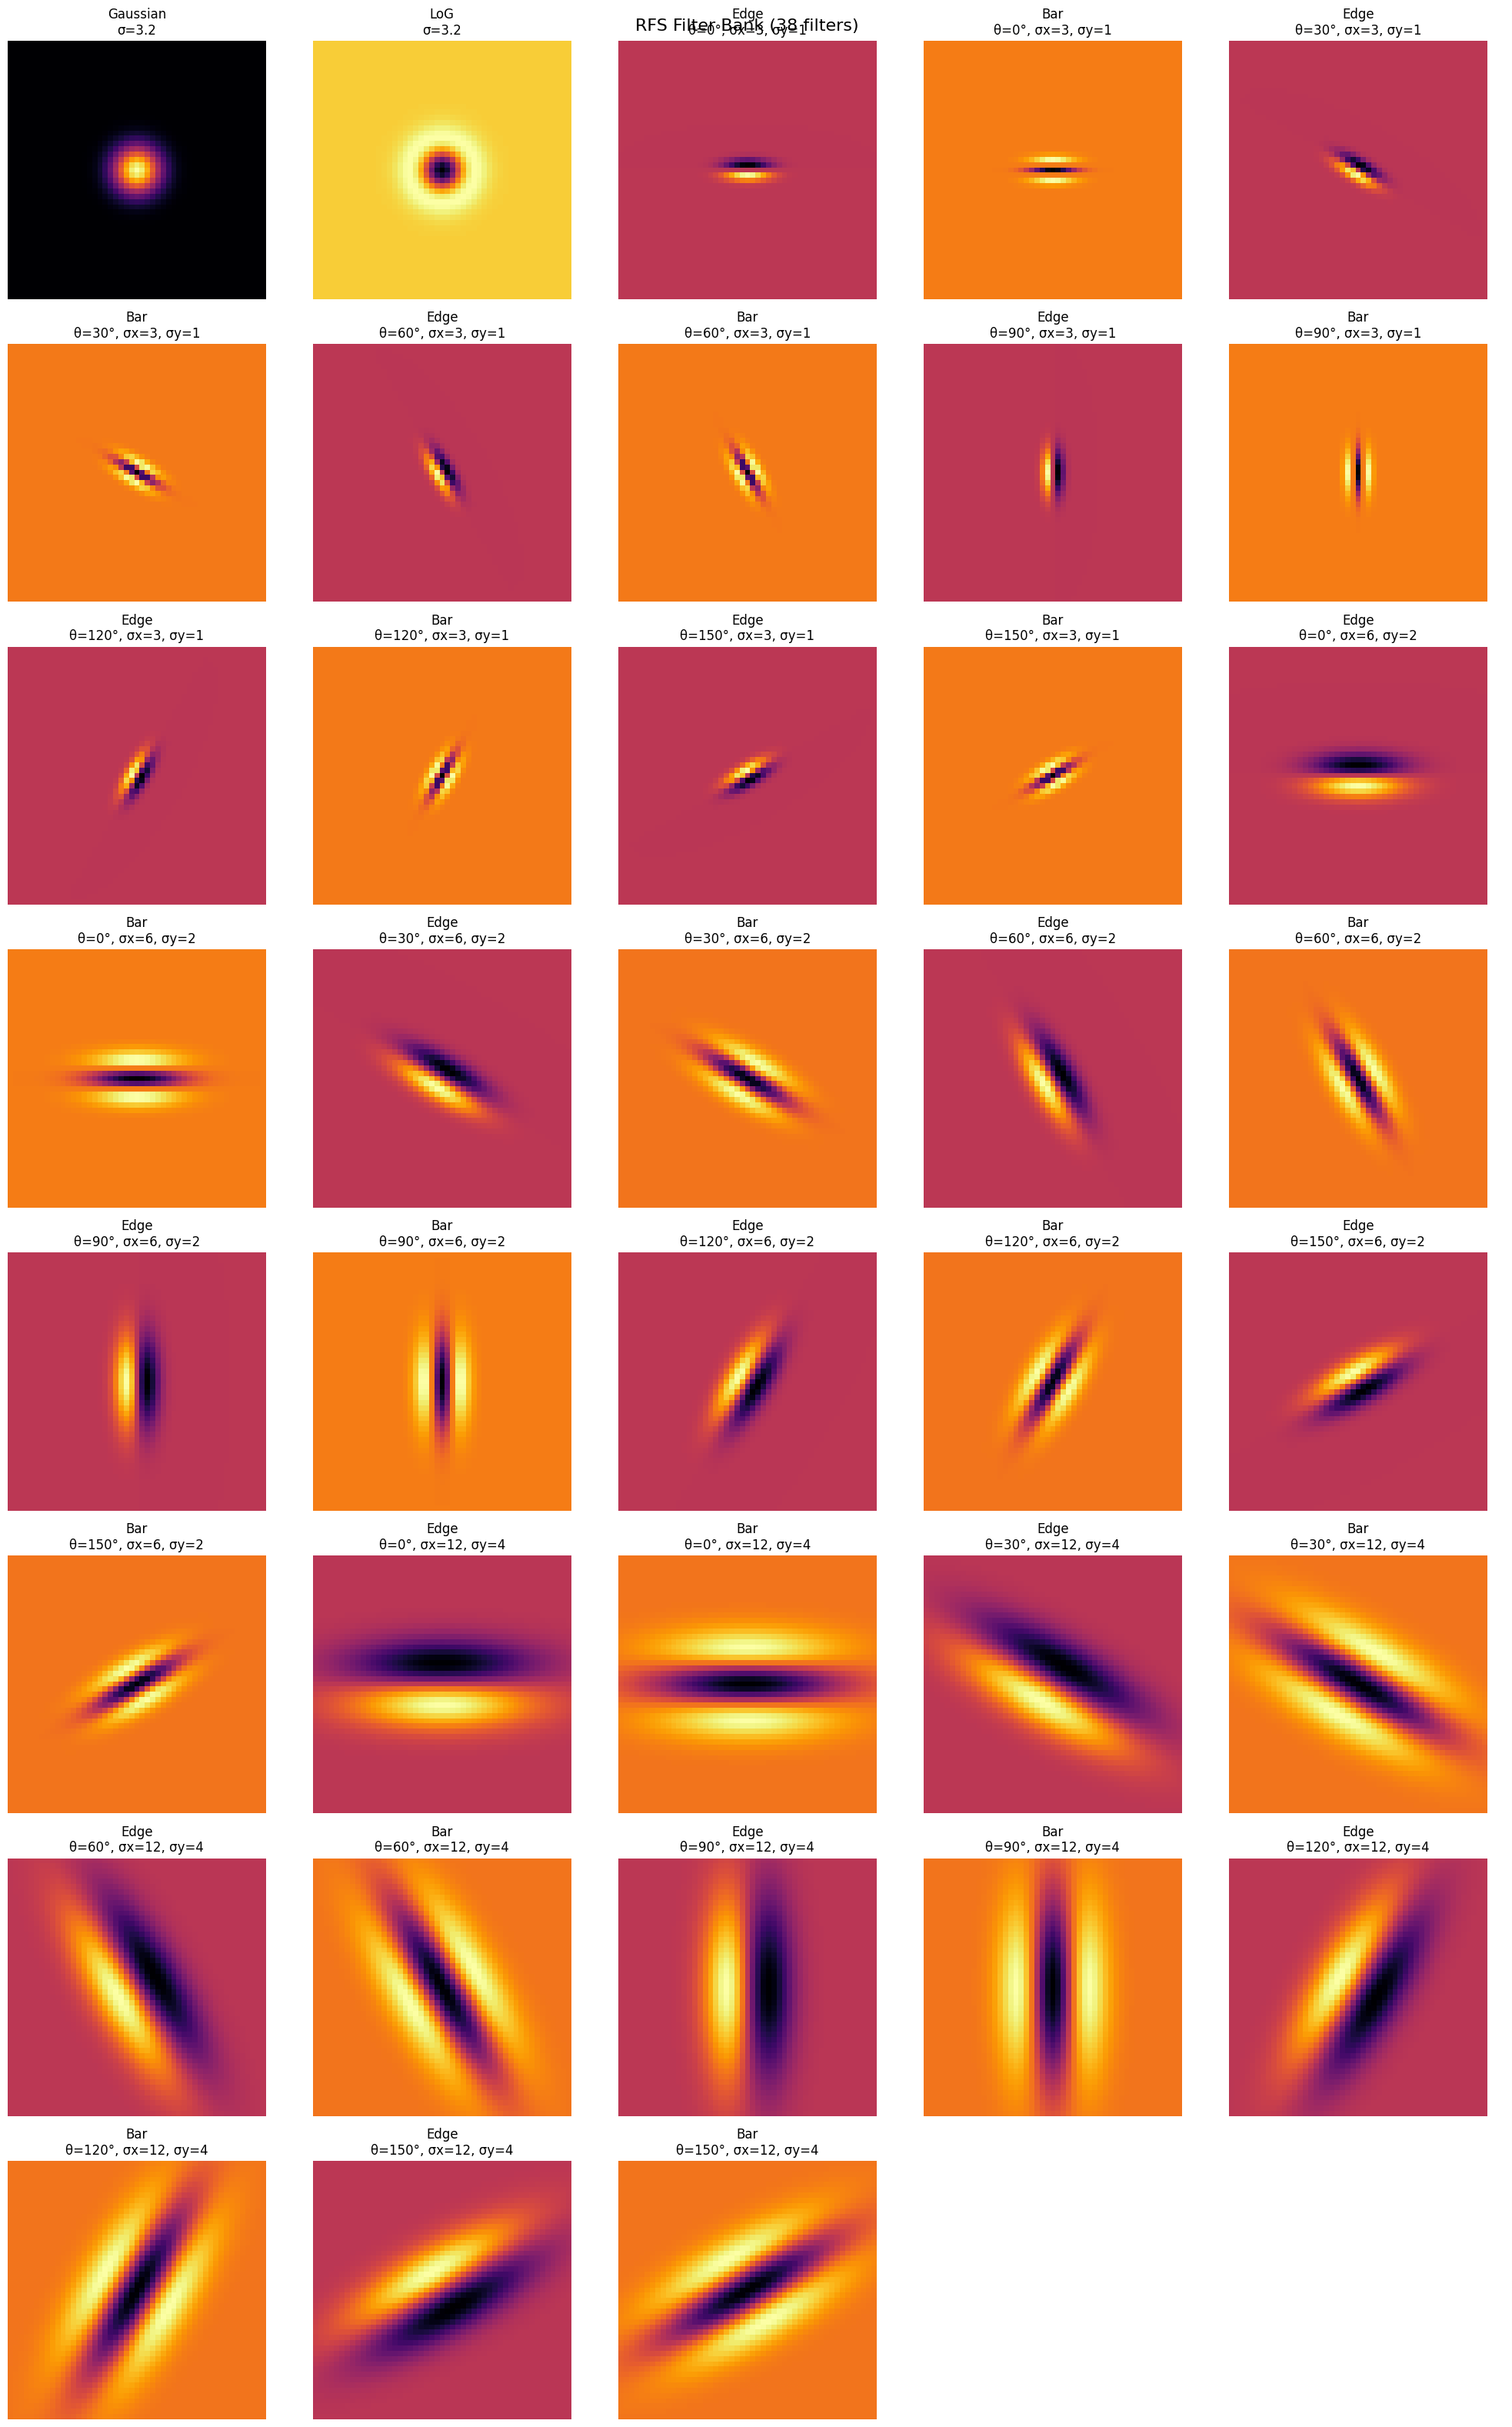

In [48]:
rfs_filters = create_rfs_filter_bank()
fig, axes = plt.subplots(8, 5, figsize=(20, 32))
axes = axes.flatten()

for i, filter_info in enumerate(rfs_filters[:38]):
    axes[i].imshow(filter_info['filter'], cmap='inferno')
    filter_type = filter_info['type']
    if filter_type in ['Gaussian', 'LoG']:
        axes[i].set_title(f"{filter_type}\nσ={filter_info['params']['sigma']:.1f}")
    else:
        theta_deg = filter_info['params']['theta'] * 180 / np.pi
        axes[i].set_title(f"{filter_type}\nθ={theta_deg:.0f}°, σx={filter_info['params']['sigma_x']}, σy={filter_info['params']['sigma_y']}")
    axes[i].axis('off')

for i in range(38, len(axes)):
    axes[i].axis('off')

plt.suptitle('RFS Filter Bank (38 filters)', fontsize=16, y=0.98)
plt.tight_layout()
plt.show()

### 2.3 MR8 Feature Extraction

In [49]:
def create_mr8_features(rfs_responses, rfs_filters):
    h, w, _, c = rfs_responses.shape
    mr8_features = np.zeros((h, w, 8, c), dtype=np.float32)
    mr8_features[:, :, 0, :] = rfs_responses[:, :, 0, :]
    mr8_features[:, :, 1, :] = rfs_responses[:, :, 1, :]
    sigma_pairs = [(3, 1), (6, 2), (12, 4)]
    feature_idx = 2
    for sigma_x, sigma_y in sigma_pairs:
        edge_indices = [i for i, f in enumerate(rfs_filters) if f['type'] == 'Edge' and f['params']['sigma_x'] == sigma_x and f['params']['sigma_y'] == sigma_y]
        bar_indices = [i for i, f in enumerate(rfs_filters) if f['type'] == 'Bar' and f['params']['sigma_x'] == sigma_x and f['params']['sigma_y'] == sigma_y]
        if edge_indices:
            edge_responses = rfs_responses[:, :, edge_indices, :]
            mr8_features[:, :, feature_idx, :] = np.max(np.abs(edge_responses), axis=2)
            feature_idx += 1
        if bar_indices:
            bar_responses = rfs_responses[:, :, bar_indices, :]
            mr8_features[:, :, feature_idx, :] = np.max(np.abs(bar_responses), axis=2)
            feature_idx += 1
    return mr8_features

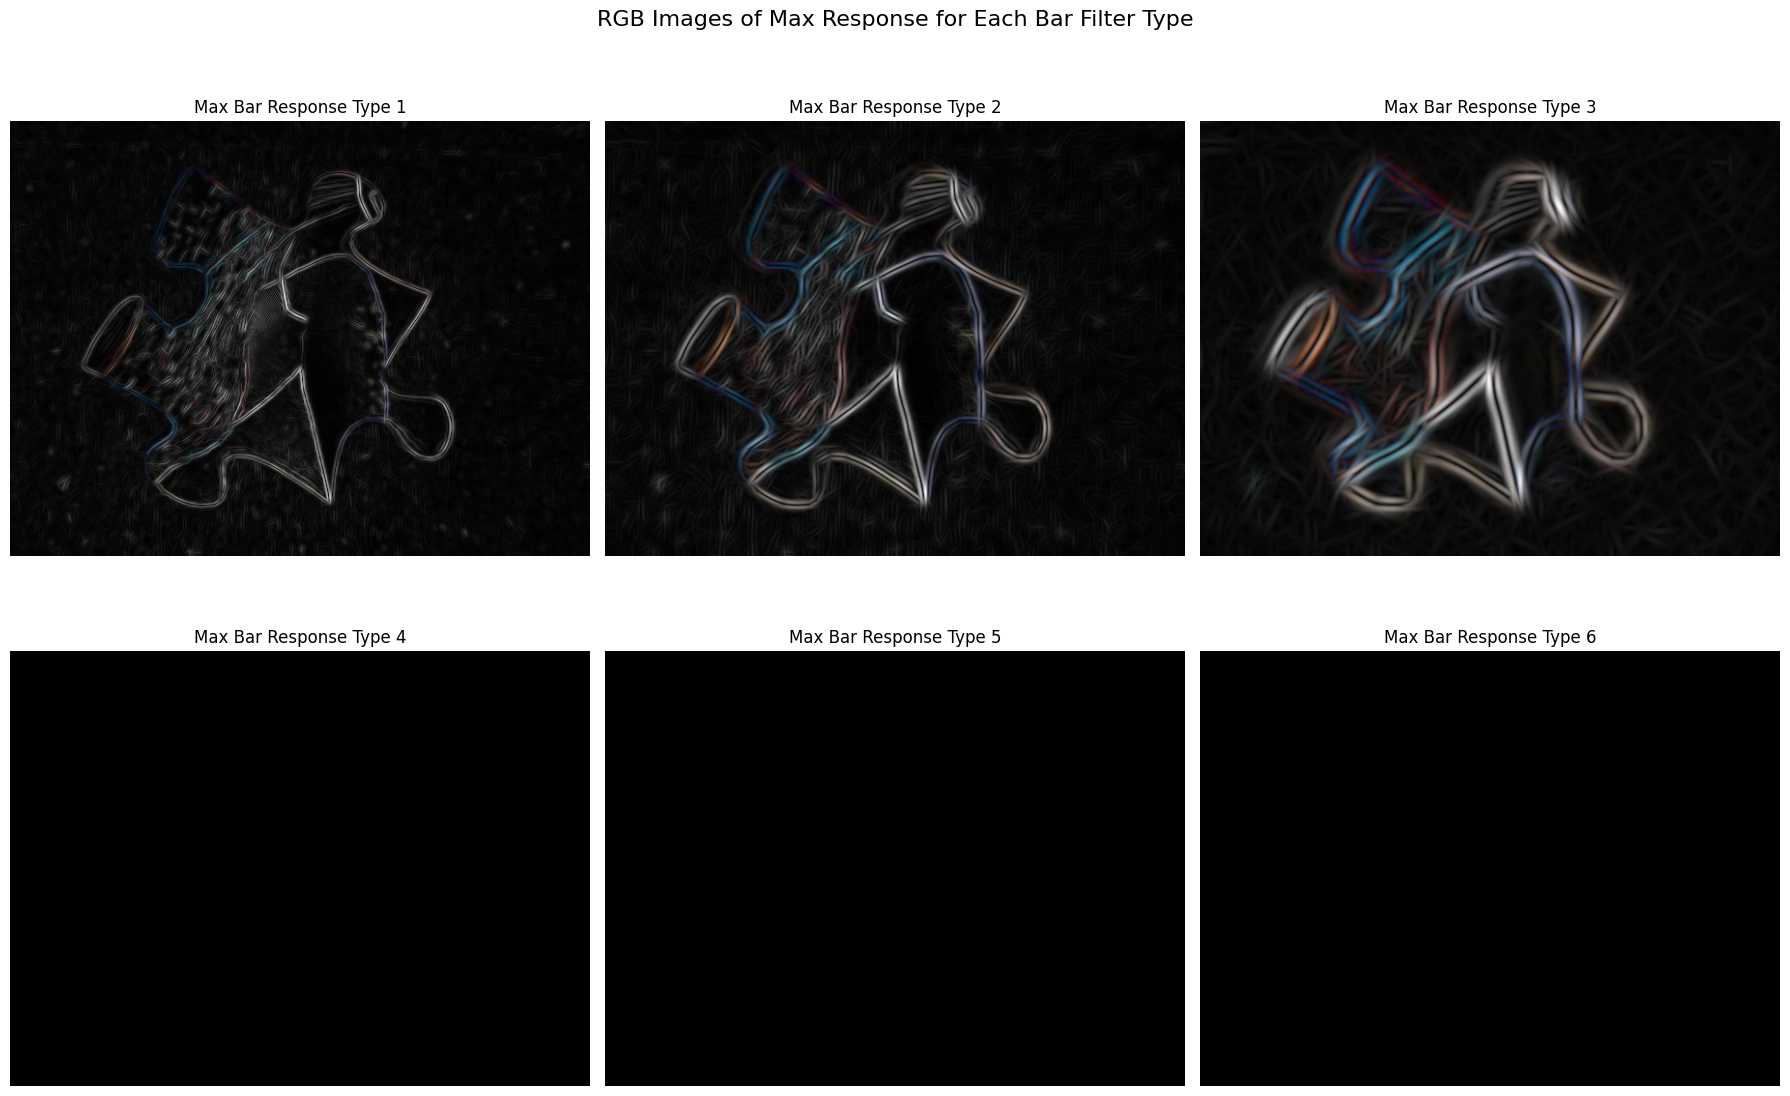

These filters detect ridges, valleys, and elongated structures at different scales and orientations.


In [50]:
def apply_rfs_filters(image, rfs_filters):
    h, w, c = image.shape
    num_filters = len(rfs_filters)
    responses = np.zeros((h, w, num_filters, c), dtype=np.float32)
    for i, filter_info in enumerate(rfs_filters):
        kernel = filter_info['filter']
        for channel in range(c):
            responses[:, :, i, channel] = cv2.filter2D(image[:, :, channel].astype(np.float32), -1, kernel)
    return responses

# Compute RFS filter responses for the training image
rfs_responses = apply_rfs_filters(train_img_rgb, rfs_filters)

bar_filter_indices = [i for i, f in enumerate(rfs_filters) if f['type'] == 'Bar']
num_bar_types = 6  # 3 scales × 2 derivatives

# Get image dimensions
h, w, c = train_img_rgb.shape

# For each channel, get the max response for each bar filter type
bar_max_responses = []
for bar_type in range(num_bar_types):
    # Each bar type corresponds to a set of orientations (6 per type)
    indices = bar_filter_indices[bar_type*6:(bar_type+1)*6]
    if len(indices) > 0:
        # For each channel, take max across orientations
        max_resp = np.max(np.abs(rfs_responses[:, :, indices, :]), axis=2)  # shape: (h, w, c)
    else:
        max_resp = np.zeros((h, w, c), dtype=np.float32)
    bar_max_responses.append(max_resp)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
for i, resp in enumerate(bar_max_responses):
    resp_norm = (resp - resp.min()) / (resp.max() - resp.min() + 1e-8)
    axes[i // 3, i % 3].imshow(resp_norm)
    axes[i // 3, i % 3].set_title(f'Max Bar Response Type {i+1}')
    axes[i // 3, i % 3].axis('off')
plt.suptitle('RGB Images of Max Response for Each Bar Filter Type', fontsize=16)
plt.tight_layout()
plt.show()

print("These filters detect ridges, valleys, and elongated structures at different scales and orientations.")


Types of features detected by these filters:
- Edge filters detect boundaries and transitions
- Bar filters detect ridges and valleys
- Different scales capture features at various sizes
- Maximum responses provide rotational invariance

## 3. Local Binary Patterns (LBP)
$$\text{LBP}(x, y) = \sum_{p=0}^{P-1} s(g_p - g_c) 2^p$$
where $g_c$ is the center pixel, $g_p$ are the neighbors, and $s$ is the threshold function.

In [51]:
def apply_lbp_features(image, radii=[4, 8, 16, 24, 32], n_points=12):
    lbp_features = {}
    for radius in radii:
        lbp = local_binary_pattern(image, n_points, radius, method='uniform')
        lbp_features[f'lbp_r{radius}'] = lbp
    return lbp_features

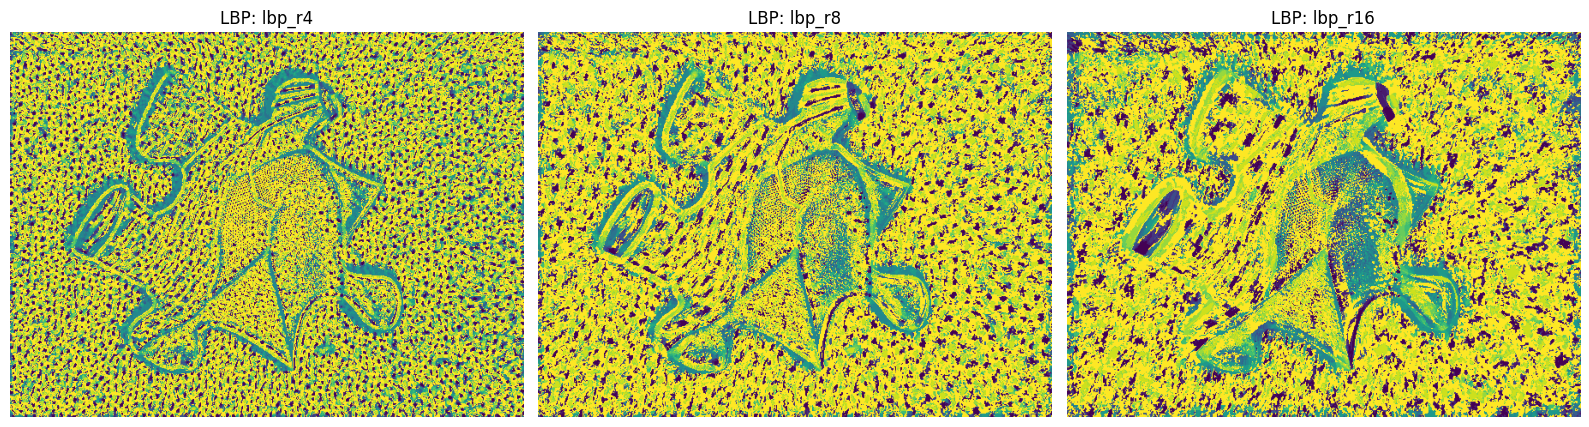

In [52]:
# Example usage of apply_lbp_features on the grayscale training image
lbp_results = apply_lbp_features(train_gray, radii=[4, 8, 16], n_points=12)

# Visualize LBP features for different radii
fig, axes = plt.subplots(1, len(lbp_results), figsize=(16, 5))
for idx, (key, lbp_img) in enumerate(lbp_results.items()):
    axes[idx].imshow(lbp_img)
    axes[idx].set_title(f'LBP: {key}')
    axes[idx].axis('off')
plt.tight_layout()
plt.show()

## 3.1 Integral Images & Haar Filters

In [53]:
def compute_integral_image(image):
    return cv2.integral(image.astype(np.float32))

def apply_haar_filter_integral(integral_img, x, y, size):
    half_size = size // 2
    if x + size >= integral_img.shape[1] or y + size >= integral_img.shape[0]: return 0
    sum_tl = (integral_img[y + half_size, x + half_size] - integral_img[y, x + half_size] - integral_img[y + half_size, x] + integral_img[y, x])
    sum_tr = (integral_img[y + half_size, x + size] - integral_img[y, x + size] - integral_img[y + half_size, x + half_size] + integral_img[y, x + half_size])
    sum_bl = (integral_img[y + size, x + half_size] - integral_img[y + half_size, x + half_size] - integral_img[y + size, x] + integral_img[y + half_size, x])
    sum_br = (integral_img[y + size, x + size] - integral_img[y + half_size, x + size] - integral_img[y + size, x + half_size] + integral_img[y + half_size, x + half_size])
    return sum_tl - sum_tr - sum_bl + sum_br

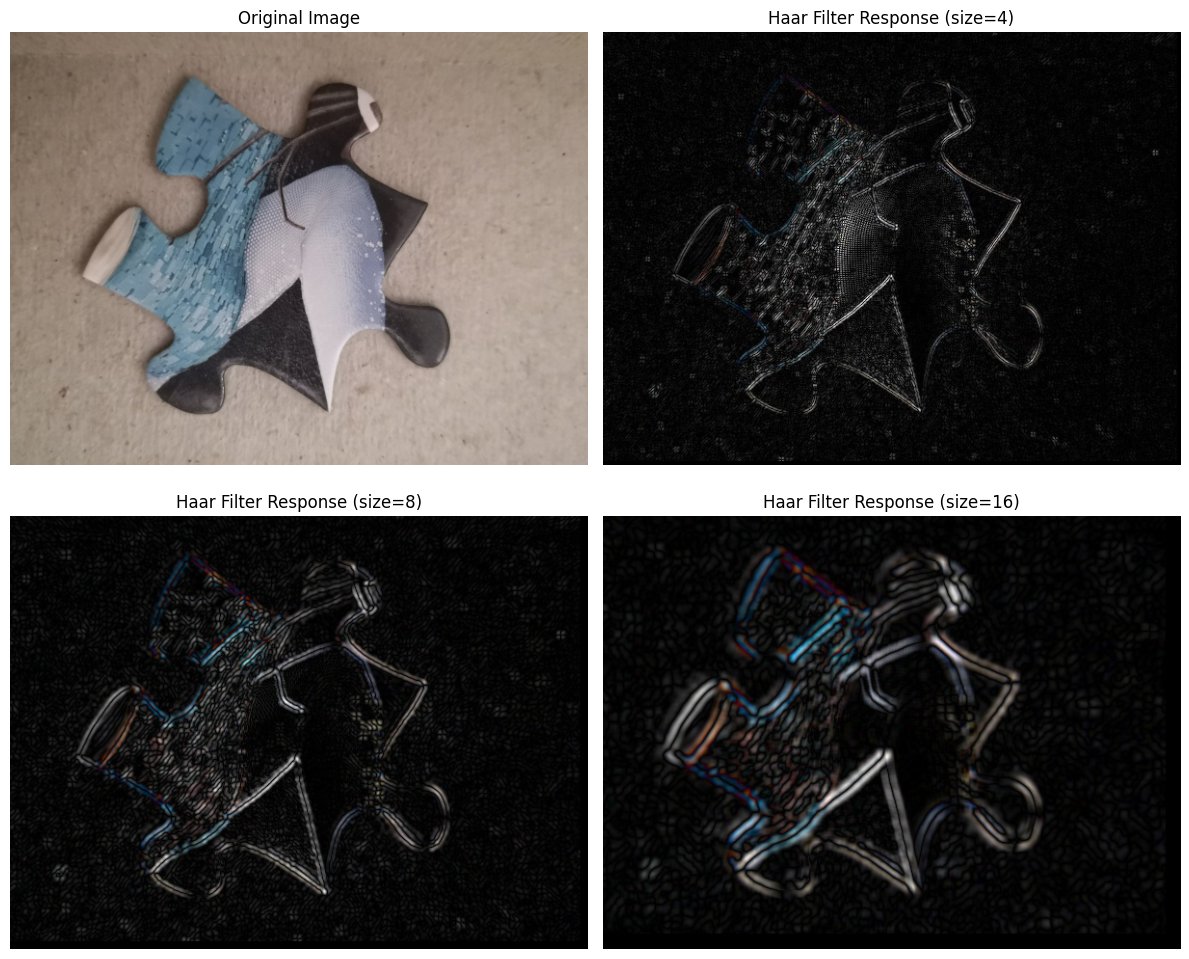

In [54]:
# Apply Haar filters to the training image
haar_filter_sizes = [4, 8, 16]
integral_images = [compute_integral_image(train_img_rgb[:, :, c]) for c in range(3)]

def apply_haar_filters_to_image(image, integral_images, sizes):
    h, w, c = image.shape
    haar_responses = {}
    for size in sizes:
        response = np.zeros((h, w, c), dtype=np.float32)
        for channel in range(c):
            for y in range(h - size):
                for x in range(w - size):
                    response[y, x, channel] = apply_haar_filter_integral(integral_images[channel], x, y, size)
        haar_responses[f'haar_{size}'] = response
    return haar_responses

haar_responses = apply_haar_filters_to_image(train_img_rgb, integral_images, haar_filter_sizes)

# Visualize Haar filter responses
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes[0, 0].imshow(train_img_rgb)
axes[0, 0].set_title('Original Image')
axes[0, 0].axis('off')

for i, size in enumerate(haar_filter_sizes):
    row = (i + 1) // 2
    col = (i + 1) % 2 if i < 2 else 1
    response = haar_responses[f'haar_{size}']
    response_norm = np.abs(response)
    response_norm = (response_norm - np.min(response_norm)) / (np.max(response_norm) - np.min(response_norm))
    axes[row, col].imshow(response_norm)
    axes[row, col].set_title(f'Haar Filter Response (size={size})')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

## 8. Feature Extraction & Clustering

In [55]:
def extract_all_features(image, image_hsv, rfs_responses, mr8_features, lbp_results, haar_responses):
    h, w, c = image.shape
    features = [image.reshape(-1, 3), image_hsv.reshape(-1, 3)]
    
    # Apply Prewitt and Laplacian to each color channel
    prewitt_x_resp = np.stack([cv2.filter2D(image[:, :, i].astype(np.float32), -1, prewitt_x) for i in range(c)], axis=-1).reshape(-1, c)
    prewitt_y_resp = np.stack([cv2.filter2D(image[:, :, i].astype(np.float32), -1, prewitt_y) for i in range(c)], axis=-1).reshape(-1, c)
    laplacian_resp = np.stack([cv2.filter2D(image[:, :, i].astype(np.float32), -1, laplacian_kernel) for i in range(c)], axis=-1).reshape(-1, c)
    features += [prewitt_x_resp, prewitt_y_resp, laplacian_resp]
    
    features.append(mr8_features.reshape(-1, 8 * c))
    features.append(lbp_results['lbp_r8'].reshape(-1, 1))
    haar_flat = []
    for size in [4, 8, 16]:
        if f'haar_{size}' in haar_responses:
            response = haar_responses[f'haar_{size}']
            padded_response = np.zeros((h, w, c))
            padded_response[:response.shape[0], :response.shape[1], :] = response
            haar_flat.append(padded_response.reshape(-1, c))
    if haar_flat:
        features.append(np.concatenate(haar_flat, axis=1))
    return np.concatenate(features, axis=1)

# 2. Extract all features including MR8 HSV features
def extract_all_features_with_mr8_hsv(image, image_hsv, rfs_responses, mr8_features, lbp_results, haar_responses, mr8_features_hsv):
    h, w, c = image.shape
    features = [image.reshape(-1, 3), image_hsv.reshape(-1, 3)]
    prewitt_x_resp = np.stack([cv2.filter2D(image[:, :, i].astype(np.float32), -1, prewitt_x) for i in range(c)], axis=-1).reshape(-1, c)
    prewitt_y_resp = np.stack([cv2.filter2D(image[:, :, i].astype(np.float32), -1, prewitt_y) for i in range(c)], axis=-1).reshape(-1, c)
    laplacian_resp = np.stack([cv2.filter2D(image[:, :, i].astype(np.float32), -1, laplacian_kernel) for i in range(c)], axis=-1).reshape(-1, c)
    features += [prewitt_x_resp, prewitt_y_resp, laplacian_resp]
    features.append(mr8_features.reshape(-1, 8 * c))
    features.append(mr8_features_hsv.reshape(-1, 8 * c))
    features.append(lbp_results['lbp_r8'].reshape(-1, 1))
    haar_flat = []
    for size in [4, 8, 16]:
        if f'haar_{size}' in haar_responses:
            response = haar_responses[f'haar_{size}']
            padded_response = np.zeros((h, w, c))
            padded_response[:response.shape[0], :response.shape[1], :] = response
            haar_flat.append(padded_response.reshape(-1, c))
    if haar_flat:
        features.append(np.concatenate(haar_flat, axis=1))
    return np.concatenate(features, axis=1)

## 9. Classification & Evaluation
Use K-Means, Naive Bayes, and Logistic Regression for pixel classification. Include all extracted features and texton labels.

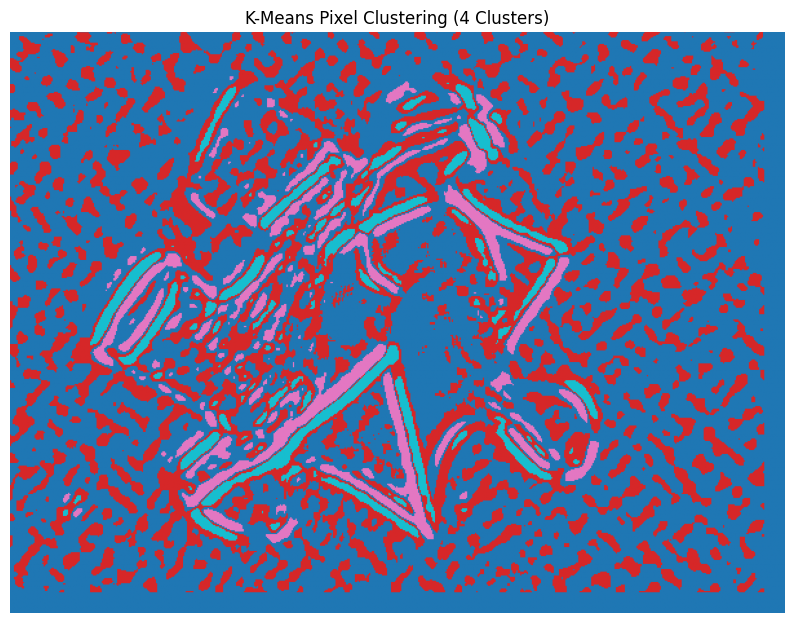

In [56]:
mr8_features = create_mr8_features(rfs_responses, rfs_filters)

# Extract all features for the training image
all_features = extract_all_features(
    train_img_rgb,
    train_img_hsv,
    rfs_responses,
    mr8_features,
    lbp_results,
    haar_responses
)

# Run K-Means clustering on the extracted features
kmeans = KMeans(n_clusters=4, random_state=42)
pixel_labels = kmeans.fit_predict(all_features)

# Reshape labels to image shape for visualization
cluster_map = pixel_labels.reshape(train_img_rgb.shape[:2])

# Visualize clustering result
plt.figure(figsize=(10, 8))
plt.imshow(cluster_map, cmap='tab10')
plt.title('K-Means Pixel Clustering (4 Clusters)')
plt.axis('off')
plt.show()

In [57]:
from scipy.stats import multivariate_normal
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def train_statistical_classifier(features, mask):
    mask_bool = mask > 0
    features_flat = features.reshape(-1, features.shape[1])
    mask_flat = mask_bool.flatten()
    fg_features = features_flat[mask_flat]
    bg_features = features_flat[~mask_flat]
    mu_fg = np.mean(fg_features, axis=0)
    mu_bg = np.mean(bg_features, axis=0)
    cov_fg = np.cov(fg_features, rowvar=False)
    cov_bg = np.cov(bg_features, rowvar=False)
    n_fg = np.sum(mask_flat)
    n_bg = np.sum(~mask_flat)
    return mu_fg, cov_fg, mu_bg, cov_bg, n_fg, n_bg

def classify_statistical_pixels(features, mu_fg, cov_fg, mu_bg, cov_bg, n_fg, n_bg):
    features_flat = features.reshape(-1, features.shape[1])
    likelihood_fg = multivariate_normal.pdf(features_flat, mu_fg, cov_fg, allow_singular=True)
    likelihood_bg = multivariate_normal.pdf(features_flat, mu_bg, cov_bg, allow_singular=True)
    prior_fg = n_fg / (n_fg + n_bg)
    prior_bg = n_bg / (n_fg + n_bg)
    numerator = likelihood_fg * prior_fg
    denominator = numerator + likelihood_bg * prior_bg
    denominator = np.clip(denominator, 1e-15, np.inf)
    posterior_fg = numerator / denominator
    return posterior_fg

def evaluate_model(predictions, ground_truth, threshold=0.5):
    pred_binary = (predictions >= threshold).astype(int)
    gt_binary = (ground_truth > 0).astype(int)
    pred_flat = pred_binary.flatten()
    gt_flat = gt_binary.flatten()
    accuracy = accuracy_score(gt_flat, pred_flat)
    precision = precision_score(gt_flat, pred_flat, zero_division=0)
    recall = recall_score(gt_flat, pred_flat, zero_division=0)
    f1 = f1_score(gt_flat, pred_flat, zero_division=0)
    cm = confusion_matrix(gt_flat, pred_flat)
    intersection = np.sum((pred_binary == 1) & (gt_binary == 1))
    union = np.sum((pred_binary == 1) | (gt_binary == 1))
    iou = intersection / union if union > 0 else 0
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm,
        'iou': iou
    }

# Extract all features for train and test images (including texton values)
train_features = extract_all_features(
    train_img_rgb,
    train_img_hsv,
    rfs_responses,
    mr8_features,
    lbp_results,
    haar_responses
)
test_features = extract_all_features(
    test_img_rgb,
    test_img_hsv,
    apply_rfs_filters(test_img_rgb, rfs_filters),
    create_mr8_features(apply_rfs_filters(test_img_rgb, rfs_filters), rfs_filters),
    apply_lbp_features(cv2.cvtColor(test_img_rgb, cv2.COLOR_RGB2GRAY), radii=[4, 8, 16], n_points=12),
    apply_haar_filters_to_image(test_img_rgb, [compute_integral_image(test_img_rgb[:, :, c]) for c in range(3)], [4, 8, 16])
)

# Train classifier
mu_fg, cov_fg, mu_bg, cov_bg, n_fg, n_bg = train_statistical_classifier(train_features, train_mask_binary)

# Classify test pixels
test_posteriors = classify_statistical_pixels(test_features, mu_fg, cov_fg, mu_bg, cov_bg, n_fg, n_bg)
test_pred_map = test_posteriors.reshape(test_img_rgb.shape[:2])

# Evaluate
metrics = evaluate_model(test_pred_map, test_mask_binary)
print("Test Accuracy:", metrics['accuracy'])
print("Test Precision:", metrics['precision'])
print("Test Recall:", metrics['recall'])
print("Test F1:", metrics['f1'])
print("Test IoU:", metrics['iou'])
print("Confusion Matrix:\n", metrics['confusion_matrix'])

Test Accuracy: 0.7745703703703704
Test Precision: 0.0
Test Recall: 0.0
Test F1: 0.0
Test IoU: 0.0
Confusion Matrix:
 [[209134      0]
 [ 60866      0]]


In [58]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

# 1. Apply MR8 feature bank to HSV pixels
rfs_responses_hsv = apply_rfs_filters(train_img_hsv, rfs_filters)
mr8_features_hsv = create_mr8_features(rfs_responses_hsv, rfs_filters)

rfs_responses_test_hsv = apply_rfs_filters(test_img_hsv, rfs_filters)
mr8_features_test_hsv = create_mr8_features(rfs_responses_test_hsv, rfs_filters)

train_features_full = extract_all_features_with_mr8_hsv(
    train_img_rgb,
    train_img_hsv,
    rfs_responses,
    mr8_features,
    lbp_results,
    haar_responses,
    mr8_features_hsv
)
test_features_full = extract_all_features_with_mr8_hsv(
    test_img_rgb,
    test_img_hsv,
    apply_rfs_filters(test_img_rgb, rfs_filters),
    create_mr8_features(apply_rfs_filters(test_img_rgb, rfs_filters), rfs_filters),
    apply_lbp_features(cv2.cvtColor(test_img_rgb, cv2.COLOR_RGB2GRAY), radii=[4, 8, 16], n_points=12),
    apply_haar_filters_to_image(test_img_rgb, [compute_integral_image(test_img_rgb[:, :, c]) for c in range(3)], [4, 8, 16]),
    mr8_features_test_hsv
)

# 3. Train a statistical classifier (Gaussian model) with new features
mu_fg_full, cov_fg_full, mu_bg_full, cov_bg_full, n_fg_full, n_bg_full = train_statistical_classifier(train_features_full, train_mask_binary)
test_posteriors_full = classify_statistical_pixels(test_features_full, mu_fg_full, cov_fg_full, mu_bg_full, cov_bg_full, n_fg_full, n_bg_full)
test_pred_map_full = test_posteriors_full.reshape(test_img_rgb.shape[:2])
metrics_full = evaluate_model(test_pred_map_full, test_mask_binary)
print("Statistical Classifier with MR8 HSV Features:")
print("Test Accuracy:", metrics_full['accuracy'])
print("Test Precision:", metrics_full['precision'])
print("Test Recall:", metrics_full['recall'])
print("Test F1:", metrics_full['f1'])
print("Test IoU:", metrics_full['iou'])
print("Confusion Matrix:\n", metrics_full['confusion_matrix'])

# 4. Train logistic regression model
y_train = train_mask_binary.flatten()
X_train = train_features_full
y_test = test_mask_binary.flatten()
X_test = test_features_full

logreg = LogisticRegression(max_iter=200, solver='lbfgs', n_jobs=-1)
logreg.fit(X_train, y_train)
test_pred_logreg = logreg.predict(X_test)
metrics_logreg = evaluate_model(test_pred_logreg.reshape(test_img_rgb.shape[:2]), test_mask_binary)
print("\nLogistic Regression Model:")
print("Test Accuracy:", metrics_logreg['accuracy'])
print("Test Precision:", metrics_logreg['precision'])
print("Test Recall:", metrics_logreg['recall'])
print("Test F1:", metrics_logreg['f1'])
print("Test IoU:", metrics_logreg['iou'])
print("Confusion Matrix:\n", metrics_logreg['confusion_matrix'])

# 5. Optional: Try feature scaling and regularization

# Use the validation image for feature scaling and logistic regression evaluation

val_features_full = extract_all_features_with_mr8_hsv(
    val_img_rgb,
    val_img_hsv,
    apply_rfs_filters(val_img_rgb, rfs_filters),
    create_mr8_features(apply_rfs_filters(val_img_rgb, rfs_filters), rfs_filters),
    apply_lbp_features(cv2.cvtColor(val_img_rgb, cv2.COLOR_RGB2GRAY), radii=[4, 8, 16], n_points=12),
    apply_haar_filters_to_image(val_img_rgb, [compute_integral_image(val_img_rgb[:, :, c]) for c in range(3)], [4, 8, 16]),
    create_mr8_features(apply_rfs_filters(val_img_hsv, rfs_filters), rfs_filters)
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(val_features_full)

param_grid = {'C': [0.01, 0.1, 1, 10]}
logreg_cv = GridSearchCV(LogisticRegression(max_iter=200, solver='lbfgs', n_jobs=-1), param_grid, cv=3, scoring='accuracy')
logreg_cv.fit(X_train_scaled, y_train)
best_logreg = logreg_cv.best_estimator_
val_pred_best = best_logreg.predict(X_val_scaled)
metrics_val = evaluate_model(val_pred_best.reshape(val_img_rgb.shape[:2]), val_mask_binary)
print("\nFinal Logistic Regression (Validation, Scaled, Tuned):")
print("Best C:", logreg_cv.best_params_['C'])
print("Validation Accuracy:", metrics_val['accuracy'])
print("Validation Precision:", metrics_val['precision'])
print("Validation Recall:", metrics_val['recall'])
print("Validation F1:", metrics_val['f1'])
print("Validation IoU:", metrics_val['iou'])
print("Confusion Matrix:\n", metrics_val['confusion_matrix'])

Statistical Classifier with MR8 HSV Features:
Test Accuracy: 0.7745703703703704
Test Precision: 0.0
Test Recall: 0.0
Test F1: 0.0
Test IoU: 0.0
Confusion Matrix:
 [[209134      0]
 [ 60866      0]]

Logistic Regression Model:
Test Accuracy: 0.9255074074074074
Test Precision: 0.9638718783436155
Test Recall: 0.6956264581211186
Test F1: 0.8080692412661151
Test IoU: 0.677949818263334
Confusion Matrix:
 [[207547   1587]
 [ 18526  42340]]

Final Logistic Regression (Validation, Scaled, Tuned):
Best C: 0.1
Validation Accuracy: 0.9722925925925926
Validation Precision: 0.9145378177600852
Validation Recall: 0.9664132756993093
Validation F1: 0.9397602003430311
Validation IoU: 0.8863657076890361
Confusion Matrix:
 [[204166   5453]
 [  2028  58353]]


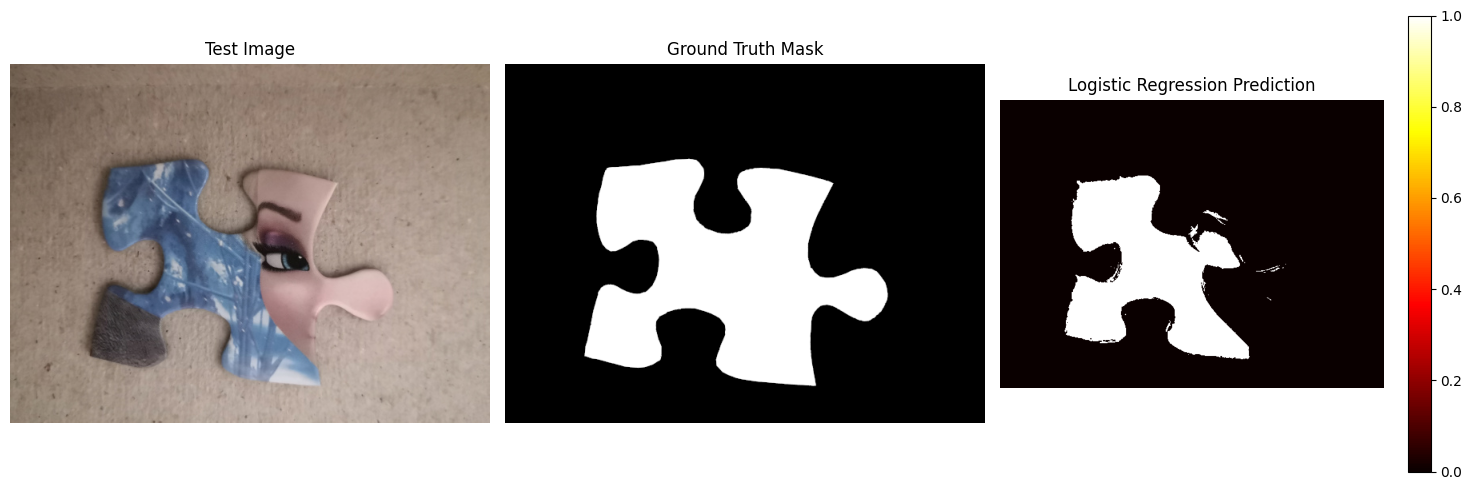

=== LOGISTIC REGRESSION TEST PERFORMANCE ===
Accuracy: 0.9255
Precision: 0.9639
Recall: 0.6956
F1 Score: 0.8081
IoU: 0.6779


In [59]:
# Reshape logistic regression predictions to image shape
logreg_pred_map = test_pred_logreg.reshape(test_img_rgb.shape[:2])

# Display test results for logistic regression
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(test_img_rgb)
axes[0].set_title('Test Image')
axes[0].axis('off')

axes[1].imshow(test_mask, cmap='gray')
axes[1].set_title('Ground Truth Mask')
axes[1].axis('off')

axes[2].imshow(logreg_pred_map, cmap='hot')
axes[2].set_title('Logistic Regression Prediction')
axes[2].axis('off')
plt.colorbar(axes[2].images[0], ax=axes[2])
plt.tight_layout()
plt.show()

# Calculate test performance for logistic regression
logreg_metrics = evaluate_model(logreg_pred_map, test_mask_binary)

print("=== LOGISTIC REGRESSION TEST PERFORMANCE ===")
print(f"Accuracy: {logreg_metrics['accuracy']:.4f}")
print(f"Precision: {logreg_metrics['precision']:.4f}")
print(f"Recall: {logreg_metrics['recall']:.4f}")
print(f"F1 Score: {logreg_metrics['f1']:.4f}")
print(f"IoU: {logreg_metrics['iou']:.4f}")